In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle
from category_encoders import LeaveOneOutEncoder


# Загрузка данных
train_data = pd.read_csv('train.csv')
print(len(train_data))

1021050


In [139]:
print(train_data.isnull().sum())
print((train_data == 0).sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count       41
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
dtype: int64


In [141]:
train_data = train_data[train_data['passenger_count'] > 0]
print(train_data.isnull().sum())
print((train_data == 0).sum())
print(len(train_data))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
1021009


In [144]:
# Определение выбросов для trip_duration
Q1 = train_data['trip_duration'].quantile(0.25)
Q3 = train_data['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Фильтрация выбросов
train_data = train_data[(train_data['trip_duration'] >= (Q1 - 3.0 * IQR)) & (train_data['trip_duration'] <= (Q3 + 3.0 * IQR))]
print(len(train_data))

1006304


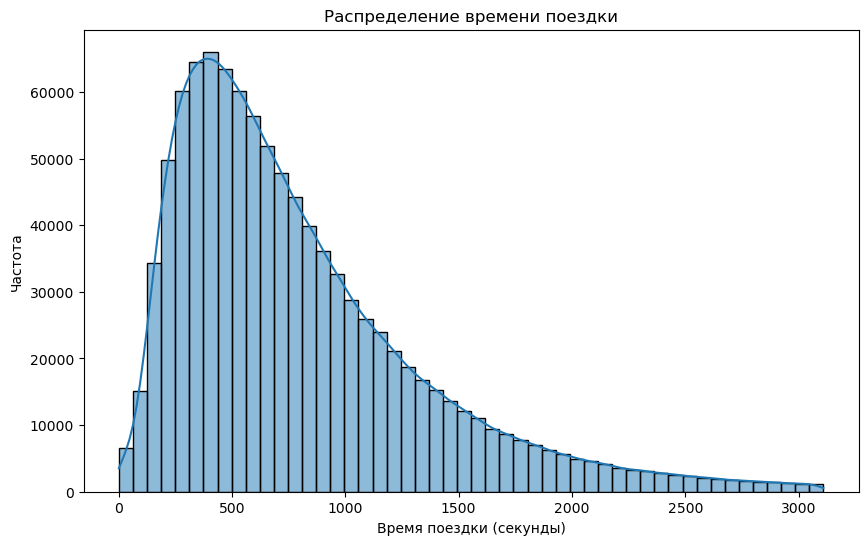

In [146]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['trip_duration'], bins=50, kde=True)
plt.title('Распределение времени поездки')
plt.xlabel('Время поездки (секунды)')
plt.ylabel('Частота')
plt.show()

<Figure size 1000x600 with 0 Axes>

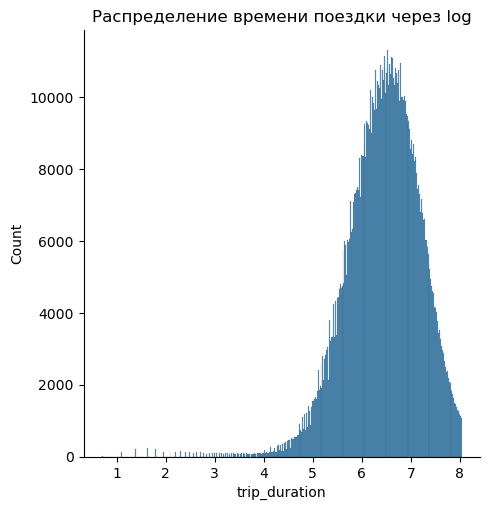

In [154]:
plt.figure(figsize=(10, 6))
sns.displot(np.log(train_data.trip_duration+1), label='area')
plt.title('Распределение времени поездки через log')
plt.show()

Через логарифм

In [159]:
train_data['trip_duration'] = train_data['trip_duration'].apply(np.log1p)

In [163]:
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])
train_data['dropoff_datetime'] = pd.to_datetime(train_data['dropoff_datetime'])

train_data['pickup_hour'] = train_data['pickup_datetime'].dt.hour
train_data['pickup_day'] = train_data['pickup_datetime'].dt.dayofweek
train_data['pickup_month'] = train_data['pickup_datetime'].dt.month
train_data['pickup_year'] = train_data['pickup_datetime'].dt.year
train_data['pickup_is_weekend'] = train_data['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)

train_data['trip_duration'] = (train_data['dropoff_datetime'] - train_data['pickup_datetime']).dt.total_seconds()

# Удаление ненужных столбцов
train_data.drop(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count'], axis=1, inplace=True)


In [389]:
# Определение признаков и целевой переменной
X = train_data.drop('trip_duration', axis=1)
y = train_data['trip_duration']

# Кодирование категориальных переменных
X = pd.get_dummies(X, columns=['store_and_fwd_flag'], drop_first=True)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, np.log1p(y_train))

# Предсказание
y_pred_log = ridge.predict(X_test)
y_pred = np.exp(y_pred_log) - 1

# Оценка модели
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse_log}')

RMSE: 261033726170.4666


Здесь видно что RMSE сильно отличается

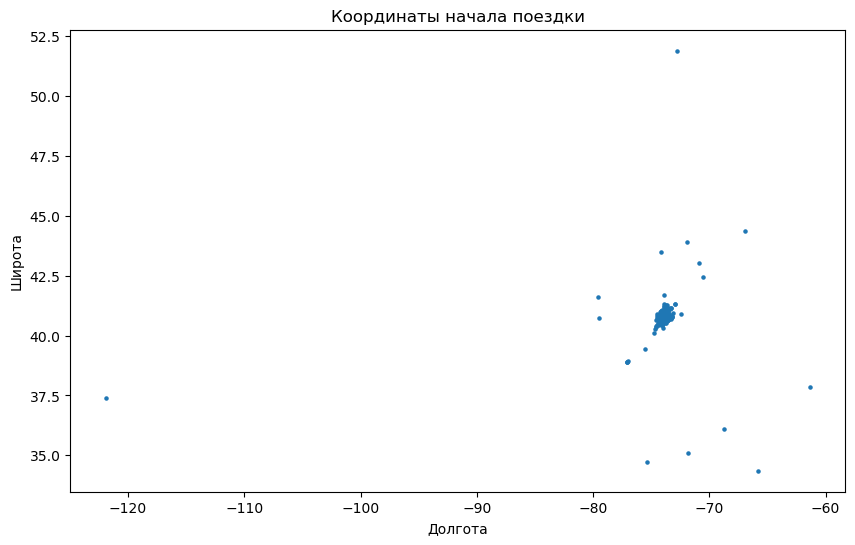

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(train_data['pickup_longitude'], train_data['pickup_latitude'], alpha=1, s=5)
plt.title('Координаты начала поездки')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

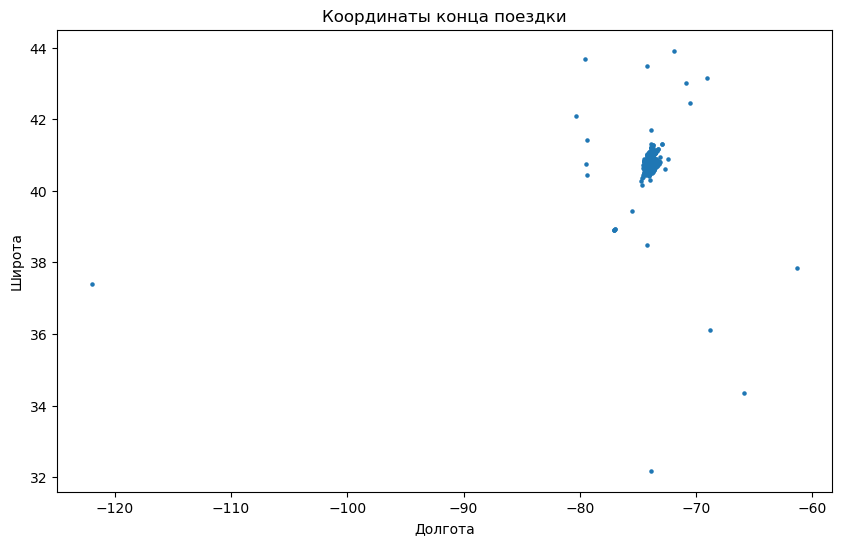

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(train_data['dropoff_longitude'], train_data['dropoff_latitude'], alpha=1, s=5)
plt.title('Координаты конца поездки')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

In [15]:
# Преобразование временных меток
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])
train_data['dropoff_datetime'] = pd.to_datetime(train_data['dropoff_datetime'])

train_data['pickup_hour'] = train_data['pickup_datetime'].dt.hour
train_data['pickup_day'] = train_data['pickup_datetime'].dt.dayofweek
train_data['pickup_month'] = train_data['pickup_datetime'].dt.month
train_data['pickup_year'] = train_data['pickup_datetime'].dt.year
train_data['pickup_is_weekend'] = train_data['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)

train_data['trip_duration'] = (train_data['dropoff_datetime'] - train_data['pickup_datetime']).dt.total_seconds()

# Удаление ненужных столбцов
train_data.drop(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count'], axis=1, inplace=True)


In [16]:
train_data['distance'] = train_data.apply(lambda row: great_circle((row['pickup_latitude'], row['pickup_longitude']),
                                                         (row['dropoff_latitude'], row['dropoff_longitude'])).meters, axis=1)
train_data.drop(['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude'], axis=1)

,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,pickup_month,pickup_year,pickup_is_weekend,distance
0,N,844.0,9,1,5,2016,0,1263.188565
1,N,1001.0,16,4,1,2016,0,4804.018835
2,N,1048.0,13,6,4,2016,1,7471.098899
3,N,784.0,17,6,1,2016,1,3444.873882
4,N,732.0,17,3,2,2016,0,2481.066244
...,...,...,...,...,...,...,...,...
1021045,N,1281.0,7,4,3,2016,0,5310.390947
1021046,N,833.0,18,1,2,2016,0,1783.779884
1021047,N,1285.0,19,1,1,2016,0,7407.656652
1021048,N,389.0,11,1,1,2016,0,642.216251


# Регуляризация и обучение модели

### Ridge

In [43]:
# Определение признаков и целевой переменной
X = train_data.drop('trip_duration', axis=1)
y = train_data['trip_duration']

# Кодирование категориальных переменных
X = pd.get_dummies(X, columns=['store_and_fwd_flag'], drop_first=True)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [44]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Предсказание
y_pred = ridge.predict(X_test)

# Оценка модели
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse_1}')


RMSE: 414.3206044104096


### Кодирование категориальных переменных с Lasso

In [48]:
from category_encoders import LeaveOneOutEncoder

In [50]:
encoder = LeaveOneOutEncoder()

In [52]:
X = train_data.drop('trip_duration', axis=1)
y = train_data['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [54]:
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [60]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

415.5523898299768

### Линейная регрессия

In [63]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

415.5288614071907

### Аналитическое решение

In [66]:
from LinearModelAnalytics import Lin_reg_analytic

analytic = Lin_reg_analytic()
analytic.fit(X_train, y_train)

In [68]:
y_pred = analytic.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

415.5288614071905

### Градиентный спуск

In [71]:
from LinearModel import LinearReg

reg = LinearReg()
reg.fit(X_train, y_train)

In [72]:
y_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

898.1119220608284

### SGD

In [74]:
from LinearModelSGD import Lin_reg_sgd

sgd = Lin_reg_sgd(lr=0.1)
sgd.fit(X_train, y_train.to_numpy())

In [75]:
y_pred = sgd.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

455.8122850812077

### Регуляризация (Lasso)

In [81]:
lasso_2 = Lasso()
lasso_2.fit(X_train, y_train)
y_pred = lasso_2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

415.5523898299768

### Кросс-Валидация

In [84]:
from sklearn.model_selection import KFold

In [86]:
kf = KFold(n_splits=5)

errors = []
models = []

for train_i, test_i in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_i], X_train[test_i]
    y_train_fold, y_test_fold = y_train.to_numpy()[train_i], y_train.to_numpy()[test_i]

    model = Lasso()
    model.fit(X_train_fold, y_train_fold)
    models.append(model)
    errors.append(np.sqrt(mean_squared_error(y_test_fold, model.predict(X_test_fold))))
    

In [87]:
preds = []
for model in models:
    preds.append(model.predict(X_test))

pred = np.mean(preds, axis=0)

In [88]:
np.mean(errors)

424.5093962114403

### Гиперпараметрическая оптимизация

In [93]:
alphas = np.linspace(0.1, 10, 100)
param_grid = {
    'alpha': alphas
}

In [95]:
grid_search = GridSearchCV(Lasso(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Lasso(random_state=42),
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])},
             scoring='neg_mean_squared_error')

In [96]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f'Best RMSE after Grid Search with Lasso: {best_rmse}')

Best RMSE after Grid Search with Lasso: 416.45268446221723


In [99]:
train_data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,pickup_month,pickup_year,pickup_is_weekend,distance
0,-73.979813,40.752529,-73.982681,40.763680,N,844.0,9,1,5,2016,0,1263.188565
1,-73.977623,40.746296,-73.968414,40.788933,N,1001.0,16,4,1,2016,0,4804.018835
2,-73.950699,40.779404,-73.863129,40.768608,N,1048.0,13,6,4,2016,1,7471.098899
3,-73.984558,40.721802,-73.976753,40.752213,N,784.0,17,6,1,2016,1,3444.873882
4,-73.967720,40.768742,-73.977173,40.789875,N,732.0,17,3,2,2016,0,2481.066244


# Используем манхетенское расстояние

In [353]:
data = pd.read_csv('train.csv')

# data = data[data['passenger_count'] > 0]
# print(train_data.isnull().sum())
# print((train_data == 0).sum())

Q1 = data['trip_duration'].quantile(0.25)
Q3 = data['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Фильтрация выбросов
data = data[(data['trip_duration'] >= (Q1 - 3.0 * IQR)) & (data['trip_duration'] <= (Q3 + 3.0 * IQR))]
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_year'] = data['pickup_datetime'].dt.year
data['pickup_is_weekend'] = data['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)

most_month = data.groupby('pickup_month')['trip_duration'].mean().reset_index()
most_days = data.groupby('pickup_day')['trip_duration'].mean().reset_index()
most_hours = data.groupby('pickup_hour')['trip_duration'].mean().reset_index()

data['time_of_day'] = data['pickup_hour'].apply(lambda x: 'ночь' if x < 6 else 
                                                  ('утро' if x < 12 else 
                                                   ('день' if x < 18 else 'вечер')))

def create_grid(lat, lon):
    lat_bins = np.linspace(30.0, 55.0, 1000)
    lon_bins = np.linspace(-125.0, -60.0, 1000)
    lat_idx = np.digitize(lat, lat_bins) - 1
    lon_idx = np.digitize(lon, lon_bins) - 1
    return lat_idx, lon_idx

data['pickup_grid'] = data.apply(lambda row: create_grid(row['pickup_latitude'], row['pickup_longitude']), axis=1)
data['dropoff_grid'] = data.apply(lambda row: create_grid(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

# Кодирование напраления маршрута
data['route'] = data.apply(lambda row: (row['pickup_grid'], row['dropoff_grid']), axis=1)
route_counts = data['route'].value_counts()
most_popular = route_counts.idxmax()

# Кодирование популярных маршрутов
data['most_popular'] = data['route'].apply(lambda x: 1 if x == most_popular else 0)

# Удаление ненужных столбцов
data.drop(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_grid', 'dropoff_grid', 'route'], axis=1, inplace=True)


<function matplotlib.pyplot.show(close=None, block=None)>

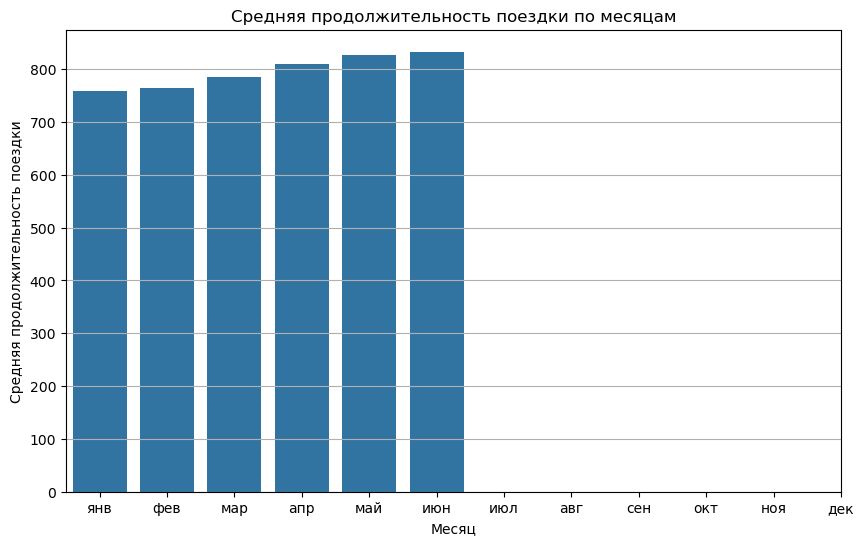

In [354]:
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_month', y='trip_duration', data=most_month)
plt.title("Средняя продолжительность поездки по месяцам")
plt.xlabel('Месяц')
plt.ylabel('Средняя продолжительность поездки')
plt.xticks(ticks=np.arange(12), labels=['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'])
plt.grid(axis='y')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

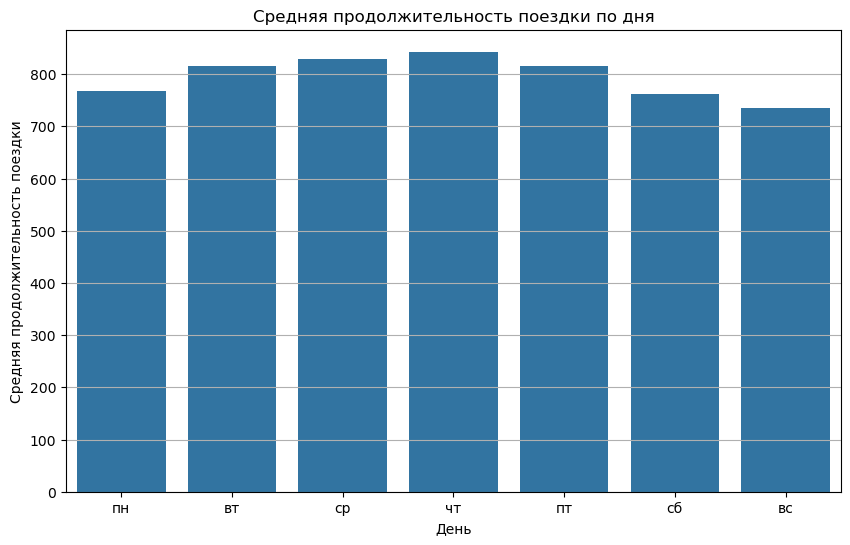

In [355]:
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_day', y='trip_duration', data=most_days)
plt.title("Средняя продолжительность поездки по дня")
plt.xlabel('День')
plt.ylabel('Средняя продолжительность поездки')
plt.xticks(ticks=np.arange(7), labels=['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
plt.grid(axis='y')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

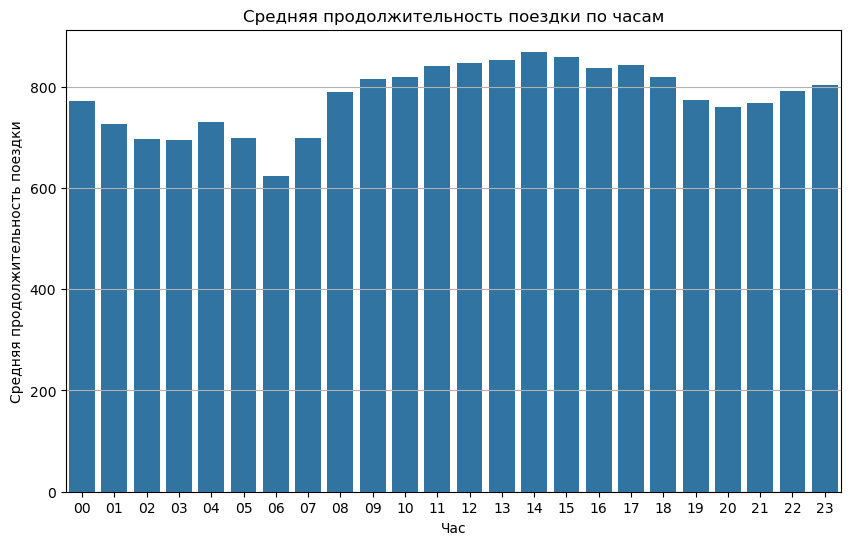

In [356]:
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_hour', y='trip_duration', data=most_hours)
plt.title("Средняя продолжительность поездки по часам")
plt.xlabel('Час')
plt.ylabel('Средняя продолжительность поездки')
plt.xticks(ticks=np.arange(24), labels=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'])
plt.grid(axis='y')
plt.show

In [357]:
hour_counts = data.groupby('pickup_hour').size().reset_index(name='order_count')
hour_counts['rolling_mean'] = hour_counts['order_count'].rolling(window=3).mean()

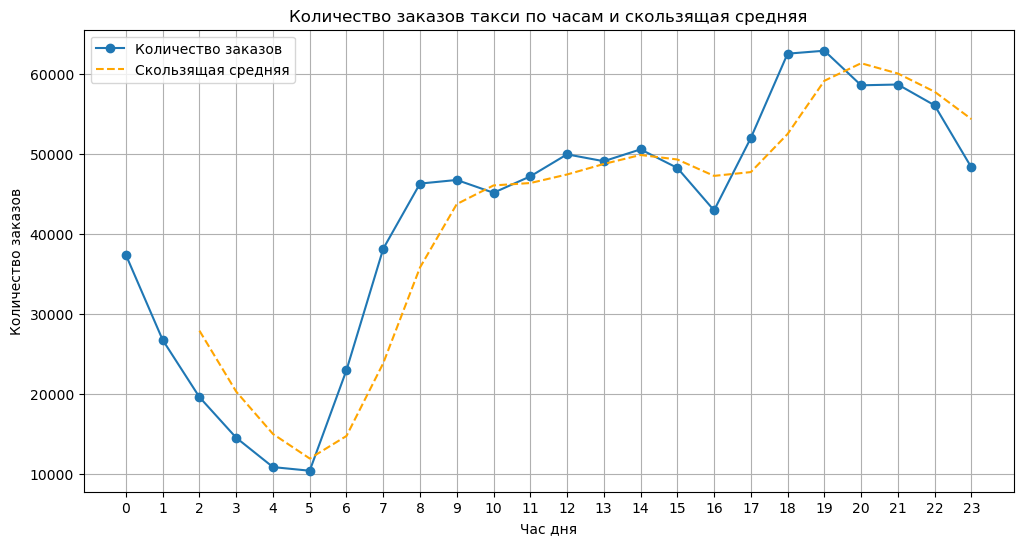

In [358]:
plt.figure(figsize=(12, 6))
plt.plot(hour_counts['pickup_hour'], hour_counts['order_count'], label='Количество заказов', marker='o')
plt.plot(hour_counts['pickup_hour'], hour_counts['rolling_mean'], label='Скользящая средняя', color='orange', linestyle='--')
plt.title('Количество заказов такси по часам и скользящая средняя')
plt.xlabel('Час дня')
plt.ylabel('Количество заказов')
plt.xticks(np.arange(0, 24, 1))
plt.grid()
plt.legend()
plt.show()

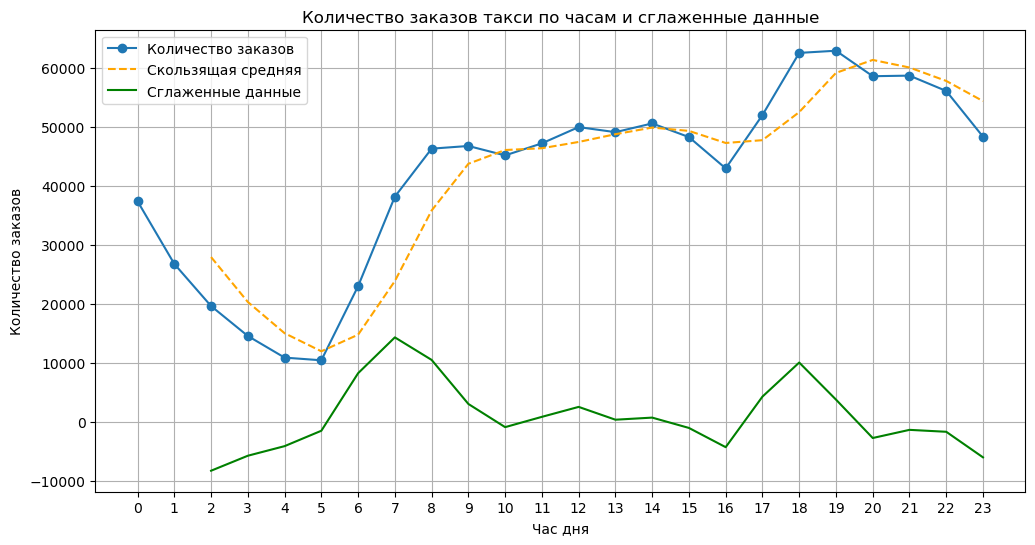

In [359]:
hour_counts['check'] = hour_counts['order_count'] - hour_counts['rolling_mean']
plt.figure(figsize=(12, 6))
plt.plot(hour_counts['pickup_hour'], hour_counts['order_count'], label='Количество заказов', marker='o')
plt.plot(hour_counts['pickup_hour'], hour_counts['rolling_mean'], label='Скользящая средняя', color='orange', linestyle='--')
plt.plot(hour_counts['pickup_hour'], hour_counts['check'], label='Сглаженные данные', color='green')
plt.title('Количество заказов такси по часам и сглаженные данные')
plt.xlabel('Час дня')
plt.ylabel('Количество заказов')
plt.xticks(np.arange(0, 24, 1))
plt.grid()
plt.legend()
plt.show()

In [360]:
data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,pickup_month,pickup_year,pickup_is_weekend,time_of_day,most_popular
0,-73.979813,40.752529,-73.982681,40.763680,N,844,9,1,5,2016,0,утро,0
1,-73.977623,40.746296,-73.968414,40.788933,N,1001,16,4,1,2016,0,день,0
2,-73.950699,40.779404,-73.863129,40.768608,N,1048,13,6,4,2016,1,день,0
3,-73.984558,40.721802,-73.976753,40.752213,N,784,17,6,1,2016,1,день,0
4,-73.967720,40.768742,-73.977173,40.789875,N,732,17,3,2,2016,0,день,0


Сглаженные данные имеют Nan в промежутке от 0 до 2 часов, следовательно обучающая модель будет плоха

In [362]:
def manhattan_distance(lat1, lon1, lat2, lon2):
    return abs(lat1 - lat2) + abs(lon1 - lon2)

data['manhattan_distance'] = data.apply(lambda row: manhattan_distance(row['pickup_latitude'], row['pickup_longitude'],
                                                                       row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
# data['distance'] = data.apply(lambda row: great_circle((row['pickup_latitude'], row['pickup_longitude']),
#                                                          (row['dropoff_latitude'], row['dropoff_longitude'])).meters, axis=1)

data.drop(['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude'], axis=1, inplace=True)


In [363]:
data.head()

,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,pickup_month,pickup_year,pickup_is_weekend,time_of_day,most_popular,manhattan_distance
0,N,844,9,1,5,2016,0,утро,0,0.014019
1,N,1001,16,4,1,2016,0,день,0,0.051846
2,N,1048,13,6,4,2016,1,день,0,0.098366
3,N,784,17,6,1,2016,1,день,0,0.038216
4,N,732,17,3,2,2016,0,день,0,0.030586


In [364]:
# Определение признаков и целевой переменной
X = data.drop('trip_duration', axis=1)
y = data['trip_duration']

# Кодирование категориальных переменных
X = pd.get_dummies(X, columns=['store_and_fwd_flag', 'time_of_day'], drop_first=True)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = Ridge()
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка модели
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse_2}')
print(f'Сравнение RMSE: без манхетенского расстояния - {rmse_1} и с манхетенским расстоянием - {rmse_2}')

RMSE: 386.93900709002764
Сравнение RMSE: без манхетенского расстояния - 414.3206044104096 и с манхетенским расстоянием - 386.93900709002764


Здесь прекрасно видно, что преминение манхетенского расстояния дало сильный прирост в предсказании модели. Будем использовать именно такой подход

In [366]:
check_data = pd.read_csv('test.csv')
check_data['pickup_grid'] = check_data.apply(lambda row: create_grid(row['pickup_latitude'], row['pickup_longitude']), axis=1)
check_data['dropoff_grid'] = check_data.apply(lambda row: create_grid(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

check_data['pickup_datetime'] = pd.to_datetime(check_data['pickup_datetime'])
check_data['dropoff_datetime'] = pd.to_datetime(check_data['dropoff_datetime'])
check_data['pickup_hour'] = check_data['pickup_datetime'].dt.hour
check_data['pickup_day'] = check_data['pickup_datetime'].dt.dayofweek
check_data['pickup_month'] = check_data['pickup_datetime'].dt.month
check_data['pickup_year'] = check_data['pickup_datetime'].dt.year
check_data['pickup_is_weekend'] = check_data['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)

data['time_of_day'] = data['pickup_hour'].apply(lambda x: 'ночь' if x < 6 else 
                                                  ('утро' if x < 12 else 
                                                   ('день' if x < 18 else 'вечер')))

# Кодирование напраления маршрута
check_data['route'] = check_data.apply(lambda row: (row['pickup_grid'], row['dropoff_grid']), axis=1)
route_counts = check_data['route'].value_counts()
most_popular = route_counts.idxmax()

# Кодирование популярных маршрутов
check_data = pd.get_dummies(check_data, columns=['store_and_fwd_flag'], drop_first=True)
check_data['most_popular'] = check_data['route'].apply(lambda x: 1 if x == most_popular else 0)
check_data['manhattan_distance'] = check_data.apply(lambda row: manhattan_distance(row['pickup_latitude'], row['pickup_longitude'],
                                                                       row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

# Удаление ненужных столбцов
check_data.drop(['id', 'vendor_id', 'pickup_datetime', 'passenger_count'], axis=1, inplace=True)
check_data.drop(['pickup_grid', 'dropoff_grid', 'route'], axis=1, inplace=True)


check_data.head()
check_data = check_data.reindex(columns=X.columns, fill_value=0)

In [367]:
test_data = pd.read_csv('test.csv')
X_scaled = scaler.transform(check_data)
test_data['trip_duration'] = model.predict(X_scaled)

In [368]:
test_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,0,1,-73.985611,40.735943,-73.980331,40.760468,N,762.769744
1,id3485529,2,2016-04-03 12:58:11,0,1,-73.978394,40.764351,-73.991623,40.749859,N,652.830826
2,id1816614,2,2016-06-05 02:49:13,0,5,-73.989059,40.744389,-73.973381,40.748692,N,632.326748
3,id1050851,2,2016-05-05 17:18:27,0,2,-73.990326,40.731136,-73.991264,40.748917,N,691.916269
4,id0140657,1,2016-05-12 17:43:38,0,4,-73.789497,40.646675,-73.987137,40.759232,N,2573.181958


In [369]:
test_data = test_data.drop(columns=['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag'], axis=1)

In [370]:
test_data.to_csv('sample_submission.csv', index=False)